In [1]:
## sleep stage classification - 2 class - using SAX features
## PAA time window = 0.1s

# http://localhost:8888/notebooks/Intern/Sleep_stage_Classification_2Class-imbalanced-data-SMOTE.ipynb
# http://localhost:8888/notebooks/GPU_run/EEG_Classification_CNN_full_SMOTE_diff_network_GPU.ipynb
# http://localhost:8888/notebooks/classification_2class_epochData_newPkl.ipynb

import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.metrics import classification_report

In [2]:
###################function to plot confusion matrix#####################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
###########################################################################################

In [3]:
## load data ##

file_location='/home/intern_eyecare/Desktop/EEG/sax_dimer' #C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data' 
os.chdir('/home/intern_eyecare/Desktop/EEG/sax_dimer') #C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data') 

# remove 2nd night of subject 13, as there was data loss - pkl file created accordingly
dfull = pickle.load(open('Frac_sax_dimer_0.1s_EEG_all_patients.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
0,0.110368,0.050167,0.016722,0.013378,0.066890,0.173913,0.060201,0.020067,0.010033,0.083612,0.163880,0.046823,0.003344,0.010033,0.063545,0.107023,400,1,s1e1,wake
1,0.090301,0.040134,0.020067,0.016722,0.050167,0.210702,0.080268,0.010033,0.020067,0.096990,0.170569,0.030100,0.006689,0.003344,0.046823,0.107023,400,1,s1e2,wake
2,0.130435,0.043478,0.003344,0.000000,0.040134,0.210702,0.053512,0.023411,0.006689,0.070234,0.167224,0.030100,0.000000,0.003344,0.050167,0.167224,400,1,s1e3,wake
3,0.123746,0.083612,0.030100,0.006689,0.050167,0.073579,0.076923,0.033445,0.050167,0.050167,0.110368,0.066890,0.020067,0.023411,0.060201,0.140468,400,1,s1e4,wake
4,0.100334,0.073579,0.050167,0.000000,0.046823,0.060201,0.096990,0.033445,0.056856,0.076923,0.133779,0.080268,0.020067,0.026756,0.063545,0.080268,400,1,s1e5,wake


In [4]:
### check the data ###
# 1. look for null values
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92994 entries, 0 to 92993
Data columns (total 20 columns):
0              92994 non-null float64
1              92994 non-null float64
2              92994 non-null float64
3              92994 non-null float64
4              92994 non-null float64
5              92994 non-null float64
6              92994 non-null float64
7              92994 non-null float64
8              92994 non-null float64
9              92994 non-null float64
10             92994 non-null float64
11             92994 non-null float64
12             92994 non-null float64
13             92994 non-null float64
14             92994 non-null float64
15             92994 non-null float64
pID            92994 non-null object
day            92994 non-null object
epoch          92994 non-null object
class_label    92994 non-null object
dtypes: float64(16), object(4)
memory usage: 14.2+ MB


In [5]:
dfull.isnull().sum()

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
pID            0
day            0
epoch          0
class_label    0
dtype: int64

In [6]:
# 2. check data distribution
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [7]:
### convert from 3-class to 2-class ###
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

## convert selected columns to string/categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'

In [ ]:
### create training & test sets ###

In [8]:
### by patient ID  ###
ID = dfull['pID'].unique() # create ID list

np.random.seed(456)   ## select the IDs for the 2 sets
msk = np.random.rand(len(ID)) < 0.8
trainIDs = pd.DataFrame()
testIDs = pd.DataFrame()
trainIDs['pID'] = ID[msk]
testIDs['pID'] = ID[~msk]
print(trainIDs['pID'].tolist())
print(testIDs['pID'].tolist())


Train = dfull.loc[dfull['pID'].isin(ID[msk])] # create the train-test sets
Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #
print(Train.shape)
print(Test.shape)
## also, check the distribution of class 0 & 1 in the train & test sets
print('Train distribution')
print(Train.groupby('class2').size())
print('')
print('Test distribution')
print(Test.groupby('class2').size())


X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()  ## create X & y splits
X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
y_train1 = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()
X_train1 = X_train1.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train1 = y_train1.drop(['index'],1)
y_test = y_test.drop(['index'],1)

['400', '401', '402', '404', '405', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419']
['403', '406']
(82992, 21)
(10002, 21)
Train distribution
class2
0    64350
1    18642
dtype: int64

Test distribution
class2
0    8041
1    1961
dtype: int64


In [ ]:
'''
### by random sampling ###
X =  dfull.drop(['pID','day','epoch','class_label','class2'], 1) # dfull[['delta','theta','alpha','beta','gamma']]
y =  dfull['class2'] 

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  #stratify=y) #stratify=True

# to test if split is stratified
y_tr = pd.DataFrame(y_train1)
y_ts = pd.DataFrame(y_test)
print('')
print(y_tr.groupby('class2').size())
print('')
print(y_ts.groupby('class2').size())
'''

In [9]:
## upsample training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train1, y_train1)


/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
check_upsample = pd.DataFrame(y_train)
check_upsample.columns = ['class2']
#check_upsample.head(2)
print(check_upsample.groupby('class2').size())

class2
0    64350
1    64350
dtype: int64


In [11]:
### data scaling ###
from sklearn.preprocessing import StandardScaler  #, MinMaxScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers 
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [12]:
### SVC model ###
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-01-31 15:28:40


In [13]:
model_svc = SVC()
model_svc.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-31 15:45:46'

In [15]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

Confusion matrix, without normalization
[[7184  857]
 [ 140 1821]]
Normalized confusion matrix
[[0.89 0.11]
 [0.07 0.93]]


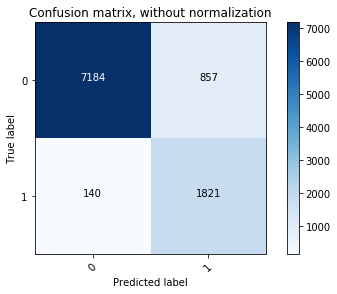

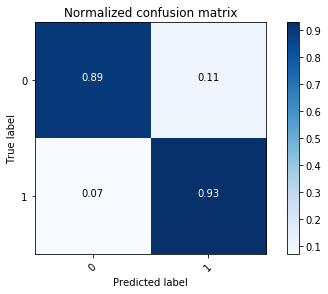

In [16]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [17]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.98      0.89      0.94      8041
           1       0.68      0.93      0.79      1961

   micro avg       0.90      0.90      0.90     10002
   macro avg       0.83      0.91      0.86     10002
weighted avg       0.92      0.90      0.91     10002



In [18]:
print(accuracy_score(y_test,y_pred))

0.9003199360127975


In [19]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.98, 0.68]),
 array([0.89, 0.93]),
 array([0.94, 0.79]),
 array([8041, 1961]))

In [20]:
p = precision_recall_fscore_support(y_test,y_pred) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.928607853136155 , spec: 0.8934212162666335


In [ ]:
##########################################################################################